<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# 05 Autoencoders y Stacked AutoEncoders


Basado en:

- [Efficient Image Segmentation](https://medium.com/data-science/efficient-image-segmentation-using-pytorch-part-3-3534cf04fb89)
- [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/)



In [ ]:
!nvidia-smi

Fri Jul  4 12:46:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. **Autoencoder**

Un **autoencoder** es una red neuronal que aprende a reconstruir su entrada después de comprimirla en una representación latente de menor dimensión.

Un autoencoder consta de dos partes:

- **Codificador (encoder)**:
  $$
  \mathbf{z} = f_{\theta}(\mathbf{x}) = \sigma(\mathbf{W}_e \mathbf{x} + \mathbf{b}_e)
  $$

- **Decodificador (decoder)**:
  $$
  \hat{\mathbf{x}} = g_{\phi}(\mathbf{z}) = \sigma'(\mathbf{W}_d \mathbf{z} + \mathbf{b}_d)
  $$

- **Función de pérdida**:
  $$
  \mathcal{L}(\mathbf{x}, \hat{\mathbf{x}}) = \| \mathbf{x} - \hat{\mathbf{x}} \|^2
  $$

## Aplicaciones
- Reducción de dimensionalidad
- Filtrado
- Detección de anomalías
- Preentrenamiento de redes profundas
- Generación de datos (en versiones como el autoencoder variacional)

Tenga en cuenta que en esta sesión de ejercicios usaremos `PyTorch` en lugar de `Keras` para construir y entrenar nuestras redes neuronales.

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# Semilla para Reproducibilidad
torch.manual_seed(42)

# Transformación del dataset de torchvision
transform = transforms.ToTensor()


train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# Seleccionando número de entradas para train y test
num_train_samples = 10000
num_test_samples = 1000

# Permutación aleatoria
train_indices = torch.randperm(len(train_data))[:num_train_samples]
test_indices = torch.randperm(len(test_data))[:num_test_samples]

# Creando el sampler
train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

## Creación de dataloaders de entrenamiento y test

In [ ]:
# Seleccionando el tamaño del batch
batch_size = 32

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler = train_subset_sampler,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          sampler = test_subset_sampler,
                                          num_workers=0)


## Visualizar datos

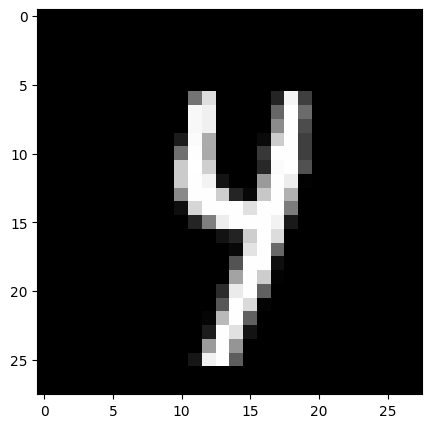

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtener una imagen del batch
images, labels = next(iter(train_loader))
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Definición: Autoencoder lineal

- Usamos el dataset MNIST
- Las imágenes originales son 28$\times$28 que usando `flatten`se convierten en vectores de 728 dimensiones
- Las imágenes ya están normalizadas de 0 a 1.
- En vista de esto, necesitamos una función de activación acorde.

Los encoder y decoder en el `AutoencoderSimple` solo tienen una capa para la representación oculta cuyo único hiperparámetro es ``encoding_dim``

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AutoencoderSimple(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoencoderSimple, self).__init__()
        # Encoder
        self.encoder = nn.Linear(784, encoding_dim)
        # Decoder
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        out = F.relu(self.encoder(x))
        out = torch.sigmoid(self.decoder(out))

        return out

class Autoencoder(nn.Module):
    def __init__(self, encoding_dims=[128, 64]):
        super(Autoencoder, self).__init__()
        # Codificador
        self.encoder = nn.Sequential(
            nn.Linear(28*28, encoding_dims[0]),
            nn.ReLU(),
            nn.Linear(encoding_dims[0], encoding_dims[1]),
            nn.ReLU()
        )
        # Decodificador
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dims[1], encoding_dims[0]),
            nn.ReLU(),
            nn.Linear(encoding_dims[0], 28*28),
            nn.Sigmoid()  # salida entre 0 y 1
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [ ]:
MODEL = "Simple"

match MODEL:
  case "Simple":
    encoding_dim = 32
    model = AutoencoderSimple(encoding_dim)
  case "Complex":
    encoder_dims = [128, 64]
    model = Autoencoder(encoder_dims)

if torch.cuda.is_available():
  model.cuda()

print(model)

AutoencoderSimple(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)


## Entrenando

Importante: como estamos ahora trabajando sobre la `representación` de las imágenes no necesitamos la salida `y`

In [ ]:
# Especificar la función de pérdida
criterion = nn.MSELoss()

# Usamos Adam como optimizador con una tasa de aprendizaje fija de 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Elegir el número de épocas para entrenar la red
n_epochs = 20

# Poner el modelo en modo entrenamiento
model.train()

for epoch in range(n_epochs):
    # Monitorear la pérdida durante el entrenamiento
    train_loss = 0.0

    # Entrenar el modelo #
    # Alimentar los datos a la red lote por lote usando el dataloader
    for batch_data in train_loader:
        # _ representa las etiquetas
        # no necesitamos etiquetas al realizar reconstrucción
        images, _ = batch_data
        # Aplanar las imágenes
        images = images.view(images.size(0), -1)
        # Enviar las imágenes a GPU si está disponible
        if torch.cuda.is_available():
            images = images.cuda()
        # Limpiar los gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # Paso hacia adelante: calcular la salida predicha pasando las entradas al modelo
        outputs = model(images)
        # Calcular la pérdida entre las imágenes de salida y las de entrada
        loss = criterion(outputs, images)
        # Paso hacia atrás: calcular el gradiente de la pérdida respecto a los parámetros del modelo
        loss.backward()
        # Realizar un solo paso de optimización (actualización de parámetros)
        optimizer.step()
        # Actualizar la pérdida acumulada
        train_loss += loss.item() * images.size(0)

    # Imprimir estadísticas promedio de entrenamiento
    train_loss = train_loss / len(train_loader)
    print('Época: {} L(Theta)=: {:.6f}'.format(
        epoch,
        train_loss
    ))


Época: 0 L(Theta)=: 2.386593
Época: 1 L(Theta)=: 1.315528
Época: 2 L(Theta)=: 1.040679
Época: 3 L(Theta)=: 0.878057
Época: 4 L(Theta)=: 0.759522
Época: 5 L(Theta)=: 0.688439
Época: 6 L(Theta)=: 0.636693
Época: 7 L(Theta)=: 0.597742
Época: 8 L(Theta)=: 0.568476
Época: 9 L(Theta)=: 0.546332
Época: 10 L(Theta)=: 0.530176
Época: 11 L(Theta)=: 0.518377
Época: 12 L(Theta)=: 0.509132
Época: 13 L(Theta)=: 0.501971
Época: 14 L(Theta)=: 0.495893
Época: 15 L(Theta)=: 0.491787
Época: 16 L(Theta)=: 0.488524
Época: 17 L(Theta)=: 0.485783
Época: 18 L(Theta)=: 0.483460
Época: 19 L(Theta)=: 0.480828


## Evaluation on test set
We now evaluate the reconstruction results on the unseen test set.
We plot the original test images and their corresponding reconstruction ones.

In [ ]:
# Poner el modelo en modo evaluación
model.eval()

# Monitorear la pérdida en el conjunto de prueba
test_loss = 0.0

# Desactivar la computación de gradientes
with torch.no_grad():
    # Iterar sobre los datos de prueba
    for batch_data in test_loader:
        # Extraer las imágenes del lote
        images, _ = batch_data
        # Aplanar las imágenes y enviarlas a GPU
        images = images.view(images.size(0), -1)
        # Enviar a GPU si está disponible
        if torch.cuda.is_available():
            images = images.cuda()
        # Paso hacia adelante: calcular las salidas predichas pasando las entradas al modelo
        outputs = model(images)
        # Calcular la pérdida entre las imágenes de salida y las de entrada
        loss = criterion(outputs, images)
        # Actualizar la pérdida de prueba
        test_loss += loss.item() * images.size(0)

# Calcular la pérdida promedio en el conjunto de prueba
test_loss = test_loss / len(test_loader.dataset)

# Imprimir la pérdida de prueba
print('Pérdida en prueba: {:.6f}'.format(test_loss))

Pérdida en prueba: 0.001470


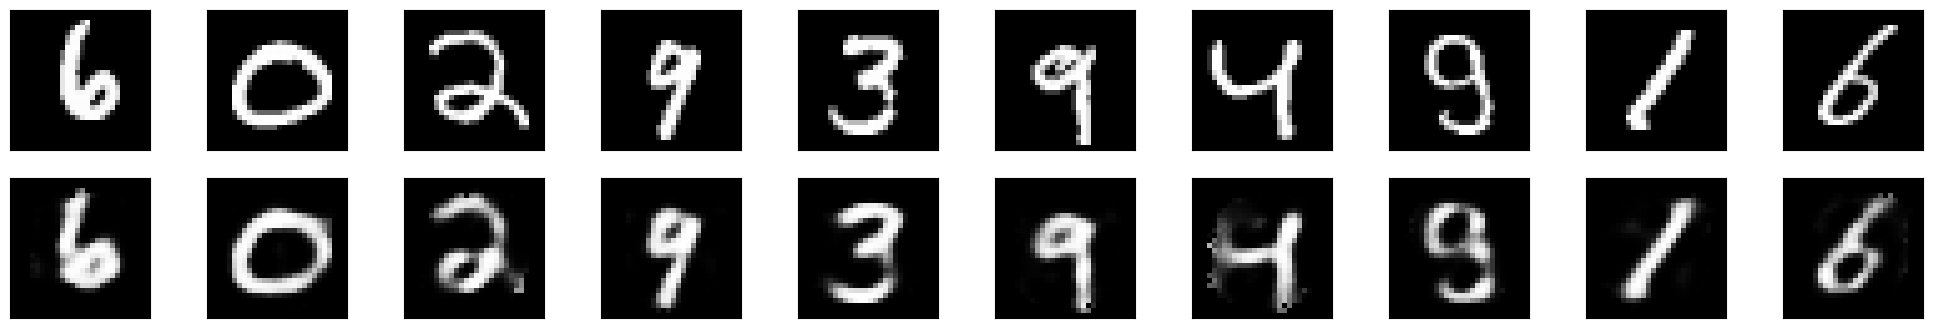

In [ ]:
# Obtener un lote de imágenes de prueba
test_images, test_labels = next(iter(test_loader))

test_images_flatten = test_images.view(test_images.size(0), -1)
# Poner el modelo en modo evaluación
model.eval()
# Enviar el modelo de vuelta a la CPU
model.cpu()
# Obtener las salidas del modelo
output = model(test_images_flatten)

# Preparar las imágenes para mostrarlas
test_images = test_images.numpy()

# La salida se redimensiona a un lote de imágenes
output = output.view(batch_size, 1, 28, 28)
# Usar detach cuando la salida requiere gradientes
output = output.detach().numpy()

# Graficar las primeras diez imágenes de entrada y sus reconstrucciones
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# Imágenes de entrada en la fila superior, reconstrucciones en la inferior
for test_images, row in zip([test_images, output], axes):
    for img, ax in zip(test_images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Aplicación: denoising!

MSE imagen original vs con ruido:     0.045285
MSE imagen original vs reconstruida:  0.031670


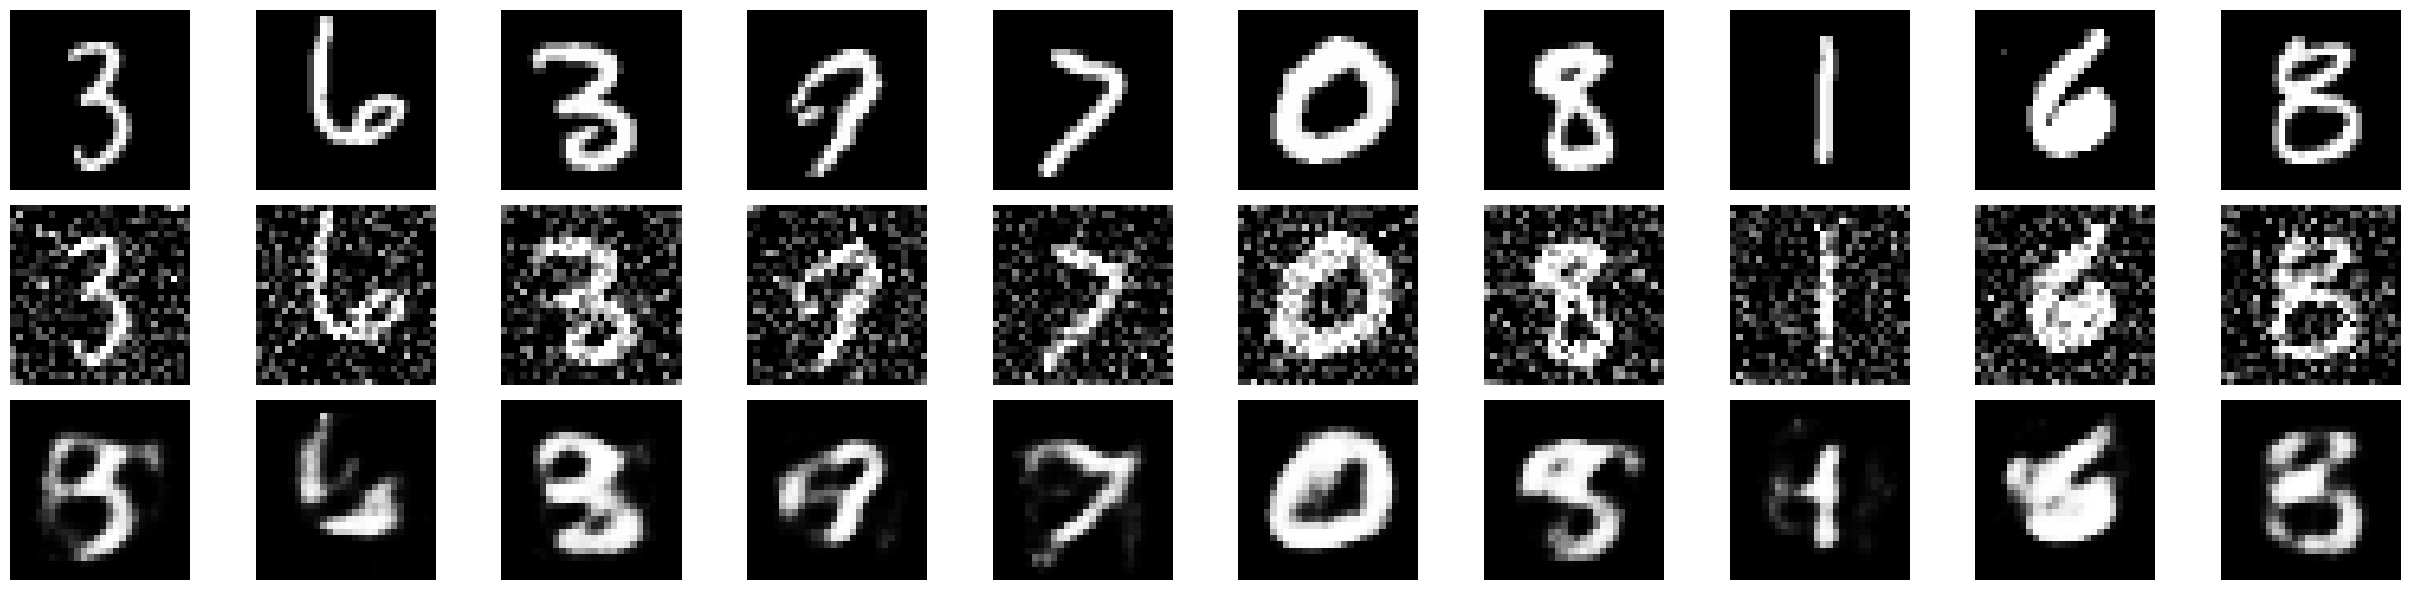

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Obtener un lote de imágenes de prueba
test_images, _ = next(iter(test_loader))
batch_size = test_images.size(0)

# Aplanar las imágenes
test_images_flatten = test_images.view(batch_size, -1)

# Poner modelo en modo evaluación y en CPU
model.eval()
model.cpu()

# Agregar ruido gaussiano controlado
np.random.seed(0)
noise = torch.randn_like(test_images_flatten) * 0.3
input_noised = test_images_flatten + noise
input_noised = torch.clamp(input_noised, 0., 1.)

# Pasar las imágenes ruidosas por el modelo
output_noised = model(input_noised)

# Calcular MSE entre:
# 1. Imagen original y con ruido
# 2. Imagen original y reconstruida
mse_ruido = F.mse_loss(input_noised, test_images_flatten).item()
mse_autoencoder = F.mse_loss(output_noised, test_images_flatten).item()

print(f"MSE imagen original vs con ruido:     {mse_ruido:.6f}")
print(f"MSE imagen original vs reconstruida:  {mse_autoencoder:.6f}")

# Preparar imágenes para visualización
original = test_images.numpy()
input_noised = input_noised.view(batch_size, 1, 28, 28).detach().numpy()
output_noised = output_noised.view(batch_size, 1, 28, 28).detach().numpy()

# Visualizar original, ruidosa y reconstruida
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,6))
titles = ['Originales', 'Con ruido', 'Reconstruidas']

for row_idx, image_set in enumerate([original, input_noised, output_noised]):
    for img, ax in zip(image_set[:10], axes[row_idx]):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.axis('off')
    axes[row_idx][0].set_ylabel(titles[row_idx], fontsize=14)

plt.tight_layout()
plt.show()


# 2. **Stacked Autoencoders**

Los **stacked autoencoders** se construyen apilando múltiples autoencoders, donde la salida del codificador anterior alimenta al siguiente.

Escribamos un ejemplo con 2 autoencoders.

## Estructura del ejemplo

- Primer codificador:
  $$
  \mathbf{z}^{(1)} = \sigma(\mathbf{W}^{(1)} \mathbf{x} + \mathbf{b}^{(1)})
  $$

- Segundo codificador:
  $$
  \mathbf{z}^{(2)} = \sigma(\mathbf{W}^{(2)} \mathbf{z}^{(1)} + \mathbf{b}^{(2)})
  $$

- Primer decodificador:
  $$
  \hat{\mathbf{z}}^{(1)} = \sigma'(\mathbf{W}^{(2)T} \mathbf{z}^{(2)} + \mathbf{b}'^{(2)})
  $$

- Segundo decodificador:
  $$
  \hat{\mathbf{x}} = \sigma'(\mathbf{W}^{(1)T} \hat{\mathbf{z}}^{(1)} + \mathbf{b}'^{(1)})
  $$

## Entrenamiento
- Entrenamiento capa por capa (greedy layer-wise)
- Ajuste fino final (_fine-tuning_) de la red completa

El proceso de entrenamiento tiene 2 etapas:

1. Cada capa es entrenada por separado
1. La red es entrenada completamente.

## Ventajas
- Aprendizaje de representaciones jerárquicas
- Mejora la compresión y la generalización



In [ ]:
import torch
from torch import nn, optim, functional, utils

from torch.nn import BCELoss, init
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import time, os

def get_mnist_loader(batch_size=32, num_train_samples = 6000, num_test_samples = 1000, normalize=True):
    """

    :return: train_loader, test_loader
    """

    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    else:
        transform = transforms.ToTensor()

    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=transform,
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=transform,
                         download=True)

    # Seleccionar los índices usando un generador
    g = torch.Generator().manual_seed(0)
    train_indices = torch.randperm(len(train_dataset), generator=g)[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset), generator=g)[:num_test_samples]

    # Crear un subsampler dependiendo de los índices
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)
    return train_loader, test_loader

## Proceso para escribir nuestro Stacked Autoencoder

Primero, debemos definir la capa `AutoEncoderLayer`.

La idea fundamental es usarla como bloque de construcción dentro de nuestro `SAE`.

In [ ]:
class AutoEncoderLayer(nn.Module):
    """
    Redes connectadas líneales para el StackAutoencoder.
    El módulo, por cada autoencoder, puede ser entrenado cuando is_training_self == True
    """
    def __init__(self, input_dim=None, hidden_dim=None, SelfTraining=False):
        super(AutoEncoderLayer, self).__init__()
        if input_dim is None or hidden_dim is None:
            raise ValueError("Agrega dimensiones correctas!")
        self.in_features = input_dim
        self.out_features = hidden_dim

        # Hacer pre-entrenamiento capa por capa si es true, o entrenar toda la red.
        self.is_training_self = SelfTraining

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.out_features, bias=True),
            nn.Sigmoid()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.out_features, self.in_features, bias=True),
            nn.Sigmoid()
        )

        # Inicialización de pesos
        #self._initialize_weights()

    def forward(self, x):
        out = self.encoder(x)

        # Si la red no está en training mode, retornar solamente la codificación del input.
        if self.is_training_self:
            return self.decoder(out)
        else:
            return out

    def lock_grad(self):
        for param in self.parameters():
            param.requires_grad = False

    def acquire_grad(self):
        for param in self.parameters():
            param.requires_grad = True

    @property
    def input_dim(self):
        return self.in_features

    @property
    def output_dim(self):
        return self.out_features

    @property
    def is_training_layer(self):
        return self.is_training_self

    @is_training_layer.setter
    def is_training_layer(self, other: bool):
        self.is_training_self = other

## Construir el StackedAutoEncoder

Conectamos cada `AutoEncoderLayer` y agregamos la capa de clasificación

In [ ]:
class StackedAutoEncoderClassifier(nn.Module):
    """
    Stack the trained autoencoder layers and add a classification layer at the end
    """

    def __init__(self, autoencoder_list=None, num_classes=10):
        super(StackedAutoEncoderClassifier, self).__init__()

        # Utilizamos solamente la capa de codificación de cada AutoEncoder
        self.encoder_layers = nn.ModuleList([autoencoder.encoder for autoencoder in autoencoder_list])
        self.num_classes = num_classes

        # La capa de clasificación toma la última salida del encoder y mapea a número de clases
        self.classification_layer = nn.Linear(autoencoder_list[-1].out_features, num_classes)

    def forward(self, x):
        encoded_representation = x
        for layer in self.encoder_layers:
            encoded_representation = layer(encoded_representation)

        # Classification layer
        output = self.classification_layer(encoded_representation)
        return output


## El entrenamiento de cada capa

Fíjense cómo se congelan las capas anteriores a `layer` y solamente obtenemos el paso hacia adelante.

In [ ]:
def train_layer(layers_list=None, layer=None, epochs=None, validate=True, batch_size = 128):
    """
    Entrenamiento greedy capa-por-capa: Si entrenamos la capa i, congelamos las capas hasta i-1
    :param layers_list:
    :param layer:
    :param epoch:
    :return:
    """
    if torch.cuda.is_available():
        for model in layers_list:
            model.cuda()

    train_loader, test_loader = get_mnist_loader(batch_size=batch_size)
    optimizer = optim.SGD(layers_list[layer].parameters(), lr=0.1)
    criterion = torch.nn.MSELoss()

    # Entrenamiento
    for epoch_index in range(epochs):
        sum_loss = 0.

        # Congelamos todos los pesos HASTA la capa i
        # Capa 0 no tiene capa previa
        if layer != 0:
            for index in range(layer):
                # Congelamos los pesos de la capa
                layers_list[index].lock_grad()

                # Asignamos la salida de la capa congelada
                layers_list[index].is_training_layer = False

        for batch_index, (train_data, _) in enumerate(train_loader):
            if torch.cuda.is_available():
                train_data = train_data.cuda()
            out = train_data.view(train_data.size(0), -1)

            # Aplicamos el paso hacia adelante hasta la capa i-1
            if layer != 0:
                for l in range(layer):
                    out = layers_list[l](out)

            # Entrenamos la capa i
            pred = layers_list[layer](out)

            optimizer.zero_grad()
            loss = criterion(pred, out)
            sum_loss += loss
            loss.backward()
            optimizer.step()
            #if (batch_index + 1) % 20 == 0:
        print("Capa de entrenamiento: {}, Época: {}/{}, Iter: {}/{}, L(theta): {:.4f}".format(
            layer, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))

        if validate:
            pass

## Entrenamiento de toda la red

Ahora podemos descongelar los parámetros de la red

In [ ]:
def train_classifier(model=None, epochs=20, fine_tuning = False, batch_size = 128):

    print(">> Comenzando entrenamiento del modelo")
    if torch.cuda.is_available():
        model.cuda()

    # Si queremos hacer fine-tuning, descongelamos los pesos de las capas
    if fine_tuning:
      for param in model.parameters():
          param.requires_grad = True
      training_phase = 'Fine-Tuning'
    else:
      training_phase = 'Classifier'

    train_loader, test_loader = get_mnist_loader(batch_size=batch_size)
    optimizer = optim.SGD(model.parameters(), lr=1)
    criterion = nn.CrossEntropyLoss()

    # Modelo en modalidad entrenamiento
    model.train()

    # Entrenamiento
    for epoch_index in range(epochs):
        sum_loss = 0.
        for batch_index, (train_data, train_labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                train_data, train_labels = train_data.cuda(), train_labels.cuda()
            x = train_data.view(train_data.size(0), -1)

            predicted_labels = model(x)

            optimizer.zero_grad()
            loss = criterion(predicted_labels, train_labels)
            sum_loss += loss
            loss.backward()
            optimizer.step()

        print("Entrenamiento {}, Época: {}/{}, Iter: {}/{}, L(theta): {:.4f}".format(training_phase, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))

    print("<< Finalizado entrenamiento de todo el modelo")
    print("Calculando accuracy del test set")

    # Colocar modelo en fase de evaluación
    model.eval()

    # Calcular accuracy en el test set
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch_data in test_loader:
            images, labels = batch_data
            images = images.view(images.size(0), -1)
            if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # Obtenemos el valor máximo
            _, predicted_labels = torch.max(outputs.data, 1)
            # Contamos predicciones correctas
            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)


    # Calculamos el accuracy del test set
    accuracy = total_correct / total_samples
    print('Accuracy en el test set: {:.6f}'.format(accuracy))
    return model, accuracy


## Entrenamiento

Los hiperparámetros por defecto de las épocas ahora se dividen en:

1. Épocas por capa
1. Épocas del clasificador
1. Épocas de Fine-tuning

In [ ]:
num_layer_wise_epochs = 10
num_classifier_epochs = 10
num_finetuning_epochs = 20
batch_size = 128

### Entrenando los AutoEncoders

In [ ]:
input_dim = 784
# Definimos nuestros AutoEncoders
# Podemos modificar el número de AutoEncoders y sus respectivas capas
encoder_1 = AutoEncoderLayer(input_dim = input_dim, hidden_dim = 256, SelfTraining=True)
encoder_2 = AutoEncoderLayer(input_dim = 256, hidden_dim = 64, SelfTraining=True)
encoder_3 = AutoEncoderLayer(input_dim = 64, hidden_dim = 32, SelfTraining=True)

encoders_list = [encoder_1, encoder_2, encoder_3]
num_layers = len(encoders_list)


# Pre-train cada capa
for level in range(num_layers):
   train_layer(layers_list=encoders_list, layer=level, epochs=num_layer_wise_epochs, validate=True, batch_size = batch_size)

Capa de entrenamiento: 0, Época: 1/10, Iter: 47/47, L(theta): 1.7479
Capa de entrenamiento: 0, Época: 2/10, Iter: 47/47, L(theta): 1.5275
Capa de entrenamiento: 0, Época: 3/10, Iter: 47/47, L(theta): 1.3270
Capa de entrenamiento: 0, Época: 4/10, Iter: 47/47, L(theta): 1.1918
Capa de entrenamiento: 0, Época: 5/10, Iter: 47/47, L(theta): 1.1290
Capa de entrenamiento: 0, Época: 6/10, Iter: 47/47, L(theta): 1.0939
Capa de entrenamiento: 0, Época: 7/10, Iter: 47/47, L(theta): 1.0561
Capa de entrenamiento: 0, Época: 8/10, Iter: 47/47, L(theta): 1.0338
Capa de entrenamiento: 0, Época: 9/10, Iter: 47/47, L(theta): 1.0189
Capa de entrenamiento: 0, Época: 10/10, Iter: 47/47, L(theta): 1.0096
Capa de entrenamiento: 1, Época: 1/10, Iter: 47/47, L(theta): 0.1803
Capa de entrenamiento: 1, Época: 2/10, Iter: 47/47, L(theta): 0.1628
Capa de entrenamiento: 1, Época: 3/10, Iter: 47/47, L(theta): 0.1465
Capa de entrenamiento: 1, Época: 4/10, Iter: 47/47, L(theta): 0.1286
Capa de entrenamiento: 1, Época: 

In [ ]:
# Modelo de StackedAutoEncoder
SAE_model = StackedAutoEncoderClassifier(autoencoder_list=encoders_list, num_classes = 10)
# Print the model
print(SAE_model)

StackedAutoEncoderClassifier(
  (encoder_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): Sigmoid()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): Sigmoid()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Sigmoid()
    )
  )
  (classification_layer): Linear(in_features=32, out_features=10, bias=True)
)


### Entrenamiento sin fine-tuning

In [ ]:
# Entrenamos el clasificador sin fine tuning
train_classifier(model=SAE_model, epochs=num_classifier_epochs, fine_tuning = False, batch_size = batch_size)

>> Comenzando entrenamiento del modelo
Entrenamiento Classifier, Época: 1/10, Iter: 47/47, L(theta): 2.2991
Entrenamiento Classifier, Época: 2/10, Iter: 47/47, L(theta): 2.3054
Entrenamiento Classifier, Época: 3/10, Iter: 47/47, L(theta): 2.3017
Entrenamiento Classifier, Época: 4/10, Iter: 47/47, L(theta): 2.3022
Entrenamiento Classifier, Época: 5/10, Iter: 47/47, L(theta): 2.3074
Entrenamiento Classifier, Época: 6/10, Iter: 47/47, L(theta): 2.2998
Entrenamiento Classifier, Época: 7/10, Iter: 47/47, L(theta): 2.2926
Entrenamiento Classifier, Época: 8/10, Iter: 47/47, L(theta): 2.2937
Entrenamiento Classifier, Época: 9/10, Iter: 47/47, L(theta): 2.2053
Entrenamiento Classifier, Época: 10/10, Iter: 47/47, L(theta): 1.9302
<< Finalizado entrenamiento de todo el modelo
Calculando accuracy del test set
Accuracy en el test set: 0.232000


(StackedAutoEncoderClassifier(
   (encoder_layers): ModuleList(
     (0): Sequential(
       (0): Linear(in_features=784, out_features=256, bias=True)
       (1): Sigmoid()
     )
     (1): Sequential(
       (0): Linear(in_features=256, out_features=64, bias=True)
       (1): Sigmoid()
     )
     (2): Sequential(
       (0): Linear(in_features=64, out_features=32, bias=True)
       (1): Sigmoid()
     )
   )
   (classification_layer): Linear(in_features=32, out_features=10, bias=True)
 ),
 0.232)

### Entrenamos el modelo con fine-tuning

In [ ]:
# Train the whole model and perform fine-tuning
train_classifier(model=SAE_model, epochs=num_finetuning_epochs, fine_tuning = True, batch_size = batch_size)

>> Comenzando entrenamiento del modelo
Entrenamiento Fine-Tuning, Época: 1/20, Iter: 47/47, L(theta): 2.3984
Entrenamiento Fine-Tuning, Época: 2/20, Iter: 47/47, L(theta): 2.2174
Entrenamiento Fine-Tuning, Época: 3/20, Iter: 47/47, L(theta): 1.6490
Entrenamiento Fine-Tuning, Época: 4/20, Iter: 47/47, L(theta): 1.6226
Entrenamiento Fine-Tuning, Época: 5/20, Iter: 47/47, L(theta): 1.6766
Entrenamiento Fine-Tuning, Época: 6/20, Iter: 47/47, L(theta): 1.5218
Entrenamiento Fine-Tuning, Época: 7/20, Iter: 47/47, L(theta): 1.1747
Entrenamiento Fine-Tuning, Época: 8/20, Iter: 47/47, L(theta): 1.0559
Entrenamiento Fine-Tuning, Época: 9/20, Iter: 47/47, L(theta): 0.9608
Entrenamiento Fine-Tuning, Época: 10/20, Iter: 47/47, L(theta): 1.0041
Entrenamiento Fine-Tuning, Época: 11/20, Iter: 47/47, L(theta): 0.6302
Entrenamiento Fine-Tuning, Época: 12/20, Iter: 47/47, L(theta): 0.7466
Entrenamiento Fine-Tuning, Época: 13/20, Iter: 47/47, L(theta): 0.7056
Entrenamiento Fine-Tuning, Época: 14/20, Iter: 

(StackedAutoEncoderClassifier(
   (encoder_layers): ModuleList(
     (0): Sequential(
       (0): Linear(in_features=784, out_features=256, bias=True)
       (1): Sigmoid()
     )
     (1): Sequential(
       (0): Linear(in_features=256, out_features=64, bias=True)
       (1): Sigmoid()
     )
     (2): Sequential(
       (0): Linear(in_features=64, out_features=32, bias=True)
       (1): Sigmoid()
     )
   )
   (classification_layer): Linear(in_features=32, out_features=10, bias=True)
 ),
 0.864)

In [ ]:
# Save the model (refer: https://pytorch.org/docs/master/notes/serialization.html)
torch.save(SAE_model, 'models/sae_model.pt')

# Fine-Tuning

**Fine-tuning** (ajuste fino) es una técnica de aprendizaje profundo que consiste en **ajustar una red neuronal previamente entrenada** (por ejemplo, en una tarea o dataset grande) para mejorar su rendimiento en una **nueva tarea o dataset relacionado**.

En lugar de entrenar un modelo desde cero, se aprovechan los **pesos preentrenados** como una buena inicialización y se continúa el entrenamiento sobre un nuevo conjunto de datos, generalmente más pequeño.

## Motivación

- Reducir el tiempo de entrenamiento
- Evitar el sobreajuste en datasets pequeños
- Transferir conocimiento aprendido en una tarea a otra relacionada

## Formalización

Supón que tienes un modelo entrenado con parámetros $\theta_0$, aprendido sobre un conjunto de datos grande $\mathcal{D}_{\text{pretrain}}$:

$$
\theta_0 = \arg\min_{\theta} \mathcal{L}_{\text{pretrain}}(\mathcal{D}_{\text{pretrain}}, \theta)
$$

Luego, en lugar de entrenar desde cero, inicias con $\theta_0$ y haces un nuevo entrenamiento sobre un conjunto más específico $\mathcal{D}_{\text{target}}$:

$$
\theta^* = \arg\min_{\theta} \mathcal{L}_{\text{target}}(\mathcal{D}_{\text{target}}, \theta)
$$

donde:

- $\mathcal{L}_{\text{target}}$ puede ser distinta a $\mathcal{L}_{\text{pretrain}}$
- En muchos casos, solo una parte de los parámetros se ajusta, mientras otros se congelan

## Estrategias de Fine-Tuning

1. **Congelar capas base y entrenar solo las finales**:
   - Ideal cuando el nuevo dataset es pequeño
   - Solo se actualizan algunos parámetros $\theta_{\text{fine}} \subset \theta$

2. **Entrenar toda la red con tasa de aprendizaje baja**:
   - Útil si el nuevo dataset es grande y similar al original
   - Se evita destruir el conocimiento previamente aprendido

3. **Descongelar gradualmente**:
   - Se entrena primero solo la cabeza (top layers), luego se descongelan capas intermedias

## Ejemplo típico de uso

- Usar un modelo como `ResNet` o `BERT` preentrenado
- Reemplazar la capa de salida final
- Entrenar solo esa capa por unas pocas épocas
- Luego ajustar toda la red con una tasa de aprendizaje pequeña


## Ventajas

- Rápida convergencia
- Buen rendimiento incluso con pocos datos
- Aprovecha representaciones generales aprendidas

## Riesgos

- Puede llevar a **catastrophic forgetting** si se entrena agresivamente sobre un nuevo dominio muy distinto
- Si el dataset nuevo es muy diferente al preentrenamiento, fine-tuning puede ser inefectivo sin más adaptación



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

### Viendo el modelo ResNet

In [ ]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Preprocesamiento para replicar la entrada de ResNet
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=transform),
    batch_size=64, shuffle=False
)

# Cargar con pesos preentrenados de ImageNet
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Congelar capas
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la cabecera de clasificación
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Solo son entrenables los parámetros de la cabecera
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):
    print(f"Época {epoch}")
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"[Congelado] Época {epoch+1} - L(Theta): {running_loss/len(train_loader):.4f}"

100%|██████████| 938/938 [02:36<00:00,  6.00it/s]


[Congelado] Época 1 - L(Theta): 0.3906


100%|██████████| 938/938 [02:31<00:00,  6.18it/s]


[Congelado] Época 2 - L(Theta): 0.1702


100%|██████████| 938/938 [02:31<00:00,  6.20it/s]


[Congelado] Época 3 - L(Theta): 0.1403
✅ Accuracy (backbone congelado): 96.18%


In [ ]:
model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy (backbone congelado): {100 * correct / total:.2f}%")

Accuracy (backbone congelado): 96.18%


# Transfer Learning (Aprendizaje por Transferencia)

**Transfer learning** es una técnica de aprendizaje automático en la que un modelo entrenado previamente sobre una tarea **se reutiliza** parcial o totalmente para otra tarea **relacionada**. En lugar de entrenar un modelo desde cero, se **aprovecha el conocimiento aprendido** en una tarea base y se adapta al nuevo problema.

## Ejemplos

- Se entrena una red profunda (por ejemplo, ResNet, BERT) en un gran dataset genérico como **ImageNet** o **Wikipedia**.
- Luego, se reutiliza ese modelo como punto de partida para una tarea diferente, como:
  - Clasificación de dígitos manuscritos (MNIST)
  - Clasificación médica de imágenes de rayos X
  - Análisis de sentimientos en tweets

## Fundamento Matemático

Supongamos:

- $\mathcal{D}_S$: conjunto de datos origen (source), con tarea $\mathcal{T}_S$
- $\mathcal{D}_T$: conjunto de datos destino (target), con tarea $\mathcal{T}_T$

El objetivo es aprender un modelo $f_T$ para la tarea $\mathcal{T}_T$, utilizando el conocimiento aprendido en $\mathcal{T}_S$, donde $\mathcal{T}_S \neq \mathcal{T}_T$ pero **comparten representación o características comunes**.

## Estrategias comunes

### 1. **Feature Extraction**
- Se congela la red base (por ejemplo, todas las capas convolucionales de ResNet).
- Se reemplaza y entrena solo la capa de salida.
- Útil cuando el nuevo conjunto de datos es pequeño.

### 2. **Fine-Tuning**
- Se inicializa con un modelo preentrenado.
- Se entrena **todo o parte del modelo** en el nuevo conjunto de datos, generalmente con una tasa de aprendizaje baja.
- Más flexible, requiere más datos y cuidado para evitar sobreajuste.

## Ventajas del Transfer Learning

- **Rápida convergencia**: el modelo ya "sabe" detectar patrones útiles.
- **Mejor rendimiento con pocos datos**: útil en contextos con datasets pequeños.
- **Reducción de costos computacionales**: evita entrenar modelos desde cero.

## Limitaciones

- Si la tarea destino es muy diferente, el conocimiento transferido puede **no ser útil** o incluso dañar el rendimiento (**negative transfer**).
- Requiere cuidado al elegir qué capas congelar o afinar.

## Ejemplos reales

- Usar un **modelo de lenguaje BERT** preentrenado para análisis de sentimientos.
- Usar **ResNet18 entrenado en ImageNet** para clasificar imágenes médicas o industriales.
- Usar una red entrenada en **predicción de series temporales financieras** para tareas similares en otro mercado.

## Resumen

| Concepto         | Explicación breve                            |
|------------------|----------------------------------------------|
| Transfer Learning| Reutilizar un modelo preentrenado            |
| Feature Extraction | Congelar red base, entrenar solo el clasificador |
| Fine-Tuning      | Afinar todo el modelo con tasas pequeñas     |


In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
